# <center>Идентификация интернет-пользователей

In [2]:
import pandas as pd
import os
from scipy.sparse import csr_matrix, hstack
import numpy as np
import pickle
from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
%matplotlib inline

В этом задании мы будем решать задачу идентификации пользователя: алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой). В качестве данных у нас посещенные сайты и дата посещения.

# 1. Начальный обзор данных

Для начала загрузим данные.

In [2]:
PATH_TO_DATA = 'capstone_user_identification/kaggle'

In [29]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


Данные у нас представлены в виде сессий длиной 10, временем посщения и идентификатором пользователя.  Сайты закодированы целыми числами. Можно заметить, что данных в некоторых сессиях не хватает. Это означает, что за сессию пользователь посетил меньше 10 сайтов.

Объединим тестовую и тренировочную выборки для дальнеших преобразований.

In [31]:
train_test_df = pd.concat([train_df, test_df], sort=False)

In [98]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null object
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


Видно, что некоторых данных нехватает. Это возникает там, где сессии короче 10.

In [45]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

В обучающей выборке – 2297 сессий челевого пользователя и 251264 сессий – других пользователей. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно. Вместо этого будем использовать roc auc.

# 2. Предобработка данных

Cначало рассмотрим посещенные сайты. Нужно избавится от пропусков в данных. Индексы сайтов нумеровались с 1, так что заменим пропуски на нули.

In [33]:
sites =['site%d' % i for i in range(1, 11)]
train_test_df_sites = train_test_df[sites].fillna(0).astype('int')
train_test_df_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178


Сами по себе полученные числовые данные не имеют смысла как признаки в задаче классификации. Сайты нельзя сравнивать и вычитать. Сайты можно рассматривать как слова при анализе текста и использовать мешок слов (сайтов). Каждому сайту будет соответствовать своя колонка, а значение в ней равно числу посещений в текущей сесси. Поскольку колонок будет очень много, а посещеных сайтов нет и большая часть значений будет нулями, то будем хранить данные в разрежаных матрицах *scipy.csr_matrix*.

In [7]:
def to_csr(X):
    '''
    Take matrix with visited sites and return corespond csr_matrix.
    '''
    data = [] #site counts
    indices = [] #column index
    indptr = [0] #count of values in row
    for i in range(len(X)):
        counts_in_row = np.unique(X[i], return_counts=True)
        data.extend(counts_in_row[1])
        indptr.append(indptr[-1] + counts_in_row[1].shape[0])
        indices.extend(counts_in_row[0])

    return csr_matrix((data, indices, indptr), shape=(len(X), max(max(X, key=lambda x: max(x))) + 1))[:, 1:]

Создадим разжеренные матрицы с помощью созданной ранее функции `to_csr`.

In [12]:
train_test_sparse = to_csr(train_test_df_sites.values)
X_train_sparse = train_test_sparse[:len(train_df)]
X_test_sparse = train_test_sparse[len(train_df):]

In [97]:
y = train_df['target']

Сохраним в pickle-файлы объекты X_train_sparse, X_test_sparse и y.

In [48]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'wb') as train_target_pkl:
    pickle.dump(y, train_target_pkl, protocol=2)

In [6]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'rb') as X_train_sparse_pkl:
    X_train_sparse = pickle.load(X_train_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'rb') as X_test_sparse_pkl:
    X_test_sparse = pickle.load(X_test_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'rb') as train_target_pkl:
    y = pickle.load(train_target_pkl)

# 3. Добавление новых признаков

В качествве новых признаков можно рассмотреть:
- **hour** - час начала сессии;
- **day** - день начала сессии;
- **day_of_week** - день недели начала сессии;
- **month** - месяц начала сессии;
- **sessoin_time** - длина сессии в секундах.

In [8]:
def feature_engineering(data):
    dataframe = data.copy()
    for column in ['time%d' % i for i in range(1, 11)]:
        dataframe[column] = pd.to_datetime(dataframe[column], format='%Y-%m-%d %H:%M:%S')
    
    for i in range(1, 10):
        dataframe['diff%d' % i] = (dataframe['time%d' % (i+1)] - dataframe['time%d' % i]).dt.total_seconds()    
    
    dataframe['session_time'] = dataframe.loc[:, ['diff%d' % i for i in range(1, 10)]].sum(axis=1)
    dataframe['month'] = dataframe['time1'].dt.month
    dataframe['day'] = dataframe['time1'].dt.day
    dataframe['day_of_week'] = dataframe['time1'].dt.dayofweek
    dataframe['hour'] = dataframe['time1'].dt.hour
    dataframe.drop(['time%d' % i for i in range(1, 11)], axis=1, inplace=True)
    dataframe.fillna(0, inplace=True)
    
    return dataframe

In [35]:
train_test_df_featured = feature_engineering(train_test_df)
train_test_df_featured.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,diff5,diff6,diff7,diff8,diff9,session_time,month,day,day_of_week,hour
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,20,3,10
2,890,941.0,3847.0,941.0,942.0,3846.0,3847.0,3846.0,1516.0,1518.0,...,0.0,1.0,0.0,23.0,1.0,26.0,2,22,5,11
3,14769,39.0,14768.0,14769.0,37.0,39.0,14768.0,14768.0,14768.0,14768.0,...,0.0,1.0,1.0,1.0,2.0,7.0,12,16,0,16
4,782,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,...,30.0,30.0,30.0,30.0,30.0,270.0,3,28,4,10
5,22,177.0,175.0,178.0,177.0,178.0,175.0,177.0,177.0,178.0,...,36.0,0.0,0.0,67.0,5.0,246.0,2,28,4,10


Посмотрим на распределения полученных параметров. Так как классы сильно не сбалансированны, то перед отображением нормализуем их.

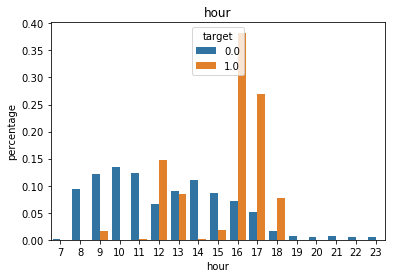

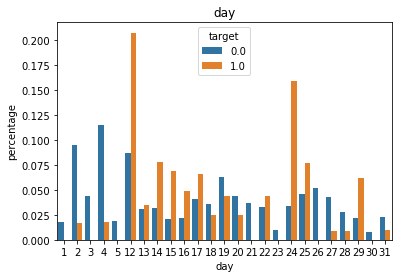

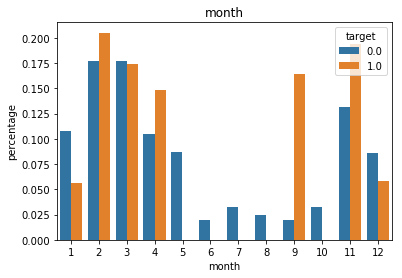

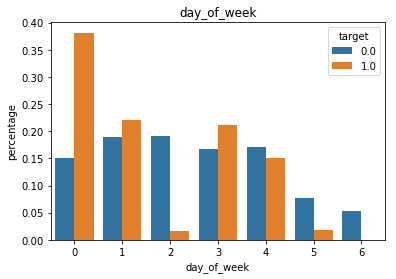

In [165]:
for feature in ['hour', 'day', 'month', 'day_of_week']:
    data = train_test_df_featured.groupby(['target'])[feature].value_counts(normalize=True).rename('percentage').reset_index()
    sns.barplot(x=feature, y='percentage', hue='target', data=data);
    plt.title(feature)
    plt.show();

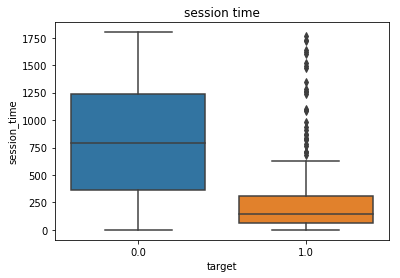

In [64]:
data = train_test_df_featured.groupby(['target'])['session_time'].value_counts().rename('percentage').reset_index()
sns.boxplot(x='target', y='session_time', data=data);
plt.title('session time')
plt.show();

* **hour** - Часы работы даны только от 7 до 23 часов. У Alice часы только между 9 и 18. Главное отличие от остальных пользователей - сильная активность в 16 и 17 часах.
* **day** - У Alice в тличии от остальных пользователей ест дни без активности и ярко выражена активность в 12 и 24 числах.
* **month** - Как и с днями есть месяцы без активности, хотя и у других пользователей она снижается в это время. Данный спад попадает на лето и, возможно, связан с отпусками и поездками (хотя захватывает также сентябрь и октябрь).
* **day_of_week** - У Alice нет активности в воскресенье и малая в среду и субботу. В отличии от остальных пользователей большая активность в понедельник.
* **session_time** - В среднем у Alice длина сессии намного меньше, но есть много выбросов.

Данные признаки у Alice отличаются от остальных пользователей и их стоит попробавать использовать для обучения.

Так как эти признаки категориальные, то их стоит закодировать с использованием one-hot-encoding, где каждому значению категориального признака отводится бинарный признак.

In [36]:
train_test_sparse_df = pd.get_dummies(train_test_df_featured.loc[:, 'month':], 
                                      columns=['month', 'day', 'day_of_week', 'hour'], prefix='')
train_test_sparse_df = train_test_sparse_df.to_sparse(0)

Объединим полученные мешок слов и новые признаки.

In [17]:
train_test_sparse_concat = hstack((train_test_sparse, csr_matrix(train_test_sparse_df.values)), 'csr')

In [18]:
X_train_sparse = train_test_sparse_concat[:len(train_df)]
X_test_sparse = train_test_sparse_concat[len(train_df):]
y = train_df['target']

In [70]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse_featured.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse_featured.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)

In [9]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse_featured.pkl'), 'rb') as X_train_sparse_pkl:
    X_train_sparse = pickle.load(X_train_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse_featured.pkl'), 'rb') as X_test_sparse_pkl:
    X_test_sparse = pickle.load(X_test_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'rb') as train_target_pkl:
    y = pickle.load(train_target_pkl)

Разобьем обучающую выборку на 2 части не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.

In [10]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

# 4. Обучение моделей

Попробуем обучить модель SGDClassifier без настройки параметров на полученных данных. Так как классы у нас сильно несбалансированы, то укажем `class_weight='balanced'`.

In [11]:
%%time
sgd_logit = SGDClassifier('log', random_state=17, n_jobs=-1, tol=1e-3, max_iter=1000, class_weight='balanced')
sgd_logit.fit(X_train, y_train)

Wall time: 880 ms


In [12]:
sgd_valid_pred_prob = sgd_logit.predict_proba(X_valid)
roc_auc_score(y_valid, sgd_valid_pred_prob[:, 1])

0.9850250141466161

Результат получился очень хорошим. Далее попробуем настроить параметры. Создадим функцию для отрисовки кривых валидации после запуска GridSearchCV.

In [20]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [120]:
%%time
param_grid = {
    'alpha':[1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}
grid_cv = GridSearchCV(SGDClassifier('log', random_state=17, n_jobs=-1, shuffle=False, 
                                     tol=1e-3, max_iter=1000, class_weight='balanced'), 
                       param_grid, n_jobs=-1, cv=5, scoring='roc_auc')
grid_cv.fit(X_train, y_train)

Wall time: 10.4 s


In [121]:
grid_cv.best_params_

{'alpha': 0.0001}

In [122]:
grid_cv.best_score_

0.9851807201343414

Посмотрим на график зависимости доли правильных ответов на кросс-валидации от C.

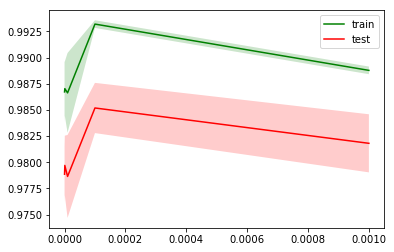

In [123]:
plot_validation_curves(param_grid['alpha'], grid_cv.cv_results_)

На графике видно, что после достижения значения параметра `alpha`, равного 1e-4, roc auc начинает падать. Значит было подобрано оптимальное значение параметра. Так же на графике нет сильного расхождения межде тренировочной и тестовой выборками, значит модель не переобучилась.

Проверим модель на отложенной выборке.

In [124]:
sgd_logit = grid_cv.best_estimator_
sgd_valid_pred_prob = sgd_logit.predict_proba(X_valid)
roc_auc_score(y_valid, sgd_valid_pred_prob[:, 1])

0.9851692985111218

Полученный результат намного лучше начального, но какой результат получиться на kaggle.

In [46]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [18]:
sgd_logit.fit(X_train_sparse, y)
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)

In [21]:
write_to_submission_file(logit_test_pred_proba[:, 1], 
                        os.path.join(PATH_TO_DATA, 'submission.csv'))

Полученный результат на kaggle: **0.93443**.

Это меньше полученного при обучении, возможно есть другие способы улучшеть его.

## 4.1 TimeSeriesSplit

Данные у нас связанны по времени, поэтому их стоит отсортировать и для кросс-валидации использовать разбиение по времени TimeSeriesSplit. В отличии от простой кросс-валидации, где данные разбиваются случайно, в TimeSeriesSplit данные используются постепенно. Сначала берется небольшая выборка из начала и последующая за ней для тестирования. Затем тестовая и проверочная выборки объядиняют и берется следующая тестовая. Это позволит учитывать связь по времени в нашей выборке. Все шаги будут теже, только будет добавлена сортировка и использование TimeSeriesSplit.

<img src=https://hsto.org/webt/8i/5k/vx/8i5kvxrehatyvf-l3glz_-ymhtw.png>

In [48]:
train_df.sort_values(by='time1', inplace=True)
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [49]:
train_test_df = pd.concat([train_df, test_df], sort=False)

In [50]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
train_test_df_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [51]:
train_test_sparse = to_csr(train_test_df_sites.values)
X_train_sparse = train_test_sparse[:len(train_df)]
X_test_sparse = train_test_sparse[len(train_df):]

In [52]:
train_test_df_featured = feature_engineering(train_test_df)
train_test_df_featured.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,diff5,diff6,diff7,diff8,diff9,session_time,month,day,day_of_week,hour
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,12,5,8
54843,56,55.0,56.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1786.0,1,12,5,8
77292,946,946.0,951.0,946.0,946.0,945.0,948.0,784.0,949.0,946.0,...,0.0,0.0,0.0,1.0,0.0,4.0,1,12,5,8
114021,945,948.0,949.0,948.0,945.0,946.0,947.0,945.0,946.0,946.0,...,0.0,1.0,0.0,0.0,1.0,3.0,1,12,5,8
146670,947,950.0,948.0,947.0,950.0,952.0,946.0,951.0,946.0,947.0,...,0.0,0.0,1.0,0.0,0.0,2.0,1,12,5,8


In [53]:
train_test_sparse_df = pd.get_dummies(train_test_df_featured.loc[:, 'session_time':], 
                                      columns=['month', 'day', 'day_of_week', 'hour'], prefix='')
train_test_sparse_df = train_test_sparse_df.to_sparse(0)

In [86]:
train_test_sparse_concat = hstack((train_test_sparse, csr_matrix(train_test_sparse_df.values)), 'csr')

In [87]:
X_train_sparse = train_test_sparse_concat[:len(train_df)]
X_test_sparse = train_test_sparse_concat[len(train_df):]

In [14]:
y = train_df['target']

In [75]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse_sorted.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse_sorted.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'train_target_sorted.pkl'), 'wb') as train_target_pkl:
    pickle.dump(y, train_target_pkl, protocol=2)

In [108]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse_sorted.pkl'), 'rb') as X_train_sparse_pkl:
    X_train_sparse = pickle.load(X_train_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse_sorted.pkl'), 'rb') as X_test_sparse_pkl:
    X_test_sparse = pickle.load(X_test_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'train_target_sorted.pkl'), 'rb') as train_target_pkl:
    y = pickle.load(train_target_pkl)

In [88]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

Используем TimeSeriesSplit вместо стандартного варианта кросс-валидации.

In [15]:
time_split = TimeSeriesSplit(5)

In [97]:
%%time
param_grid = {
    'alpha':np.linspace(1e-7, 1e-3, 100)
}
grid_cv = GridSearchCV(SGDClassifier('log', random_state=17, shuffle=False, 
                                     class_weight='balanced', tol=1e-3), 
                       param_grid, n_jobs=-1, cv=time_split, scoring='roc_auc')
grid_cv.fit(X_train, y_train)

Wall time: 55.5 s


In [98]:
grid_cv.best_params_

{'alpha': 0.0009191999999999999}

In [99]:
grid_cv.best_score_

0.7128896658828486

In [100]:
sgd_logit = grid_cv.best_estimator_
sgd_valid_pred_prob = sgd_logit.predict_proba(X_valid)
roc_auc_score(y_valid, sgd_valid_pred_prob[:, 1])

C:\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.778472865654642

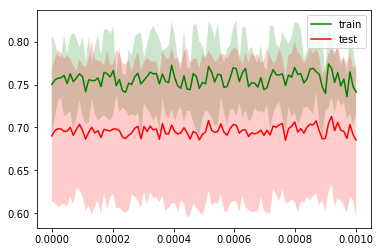

In [101]:
plot_validation_curves(param_grid['alpha'], grid_cv.cv_results_)

SGDClassifier совсем не справляется с текущей задачей. Попробуем другую модель - LogisticRegression.

In [102]:
%%time
param_grid = {
    'C':np.logspace(-2, 2, 10)    
}

grid_cv = GridSearchCV(LogisticRegression(random_state=17, class_weight='balanced'), 
                       param_grid, n_jobs=-1, cv=time_split, scoring='roc_auc',
                      verbose=1)
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


Wall time: 2min 27s


In [103]:
grid_cv.best_params_

{'C': 0.0774263682681127}

In [104]:
grid_cv.best_score_

0.9232202076126066

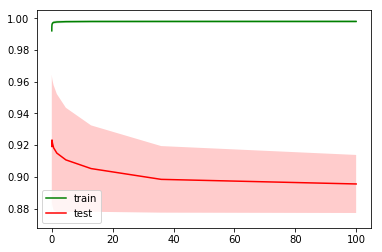

In [107]:
plot_validation_curves(param_grid['C'], grid_cv.cv_results_)

In [105]:
logit_reg = grid_cv.best_estimator_
logit_valid_pred_prob = logit_reg.predict_proba(X_valid)
roc_auc_score(y_valid, logit_valid_pred_prob[:, 1])

0.9506951606428773

У LogisticRegression получается классифицировать с приемлемой точность. Хотя проверочной выборке результат меньше чем в начале, но посмотрим на результат на kaggle.

In [56]:
%%time
logit_reg.fit(X_train_sparse, y)
logit_test_pred_proba = logit_reg.predict_proba(X_test_sparse)

Wall time: 14.1 s


In [57]:
write_to_submission_file(logit_test_pred_proba[:, 1], 
                        os.path.join(PATH_TO_DATA, 'submission.csv'))

Результат на kaggle: **0.94013**. 

Это выше предыдущего.

## 4.2 TfIdf

Имеющиеся данные представляют набор последовательно посещенных сайтов. Это напоминает последовательность слов в тексте. Используя эту схожесть можно пременить метод, используемый для текстов, - Tfidf. В истории посещений, как и в тексте, могут встречаться стоп-слова (сайты), которые, скорее всего, не несут важной информации. Данный метод позволит исключить такие слова (сайты).

In [54]:
tfidf_vector = TfidfVectorizer(max_features=50000, ngram_range=(1, 3))
text_df = train_test_df_sites.astype(np.str).apply(' '.join, axis=1)
words = tfidf_vector.fit_transform(text_df.values)
words

C:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


<336358x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 4433718 stored elements in Compressed Sparse Row format>

In [55]:
train_test_sparse_concat = hstack((words, csr_matrix(train_test_sparse_df)), 'csr')

In [56]:
X_train_sparse = train_test_sparse_concat[:len(train_df)]
X_test_sparse = train_test_sparse_concat[len(train_df):]
y = train_df['target']

In [81]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse_sorted_tfidf.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse_sorted_tfidf.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)

In [58]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse_sorted_tfidf.pkl'), 'rb') as X_train_sparse_pkl:
    X_train_sparse = pickle.load(X_train_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse_sorted_tfidf.pkl'), 'rb') as X_test_sparse_pkl:
    X_test_sparse = pickle.load(X_test_sparse_pkl)

In [57]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

In [82]:
%%time
param_grid = {
    'C':np.logspace(-2, 2, 10)    
}

grid_cv = GridSearchCV(LogisticRegression(random_state=17, class_weight='balanced'), 
                       param_grid, n_jobs=-1, cv=time_split, scoring='roc_auc',
                      verbose=1)
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


Wall time: 2min 28s


In [83]:
grid_cv.best_params_

{'C': 0.5994842503189409}

In [84]:
grid_cv.best_score_

0.924175260317651

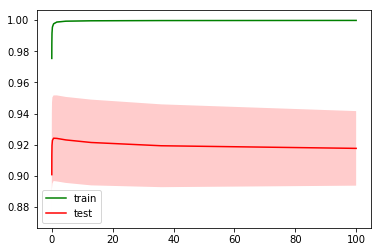

In [85]:
plot_validation_curves(param_grid['C'], grid_cv.cv_results_)

In [69]:
logit_reg = grid_cv.best_estimator_
logit_valid_pred_prob = logit_reg.predict_proba(X_valid)
roc_auc_score(y_valid, logit_valid_pred_prob[:, 1])

0.9441677590401508

Изменения на валидационной выборке небольшие. Проверим на kaggle.

In [70]:
%%time
logit_reg.fit(X_train_sparse, y)
logit_test_pred_proba = logit_reg.predict_proba(X_test_sparse)

Wall time: 15.8 s


In [71]:
write_to_submission_file(logit_test_pred_proba[:, 1], 
                        os.path.join(PATH_TO_DATA, 'submission.csv'))

Полученный результат на kaggle: **0.94771**. 

Это лучше предыдущего результата. Предположение о схожести наших данных с текстом можно считать оправданным. Можно заметить, что значение roc auc в модели без сортировки данных выше, но конечный результат ниже.

# Вывод

Цель данной работы было на основании истории посещения пользователями сайтов идентифицировать конкретного пользователя. Для этого были рассмотрены разные модели и выбрана лучшая на основе метрики roc auc. Для достидения максимального результата был проведен анализ данных с последующим их преобразование и добавлением новых признаков. Наилучший результат показала модель Logistic Regression с сортировкой данных по времени и применением tfidf. Помимо этого в качестве признаков были использованы:
- **hour**;
- **day**;
- **day_of_week**;
- **month**;
- **sessoin_time**.

Если посмотреть на работу в целом, то можно сказать, что задача классификацию одного пользователя из множества других вполне выполнима с приемлемой точностью, но далёкой от 1. Вполне возможно использовать для данной задачи ансамбли моделей или нейронные сети.